## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [756]:
# Install libraries the first time
# !pip install -q ipynb yfinance pandas pathlib numpy

### Importing Required Libraries

In [757]:
from fastai.tabular.all import *
import yfinance as yf
import pandas as pd
import pathlib
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from fastai.metrics import rmse, mae

### Global Variables

In [758]:
# Model settings
modelName = 'stockScreenerV5.0'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = '1%'  # 'ALL' for all tickers, 'None' for no prediction

# Training parameters
trainingSize = 80  # Number of stocks to use for training
timeFrame = 'max'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
catNames = ['Date']
contNames = ['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'EV/EBIT', 'ROIC']
epochs = 3

# Testing parameters
testSize = 220  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Remove Duplicate Tickers

In [759]:
df = pd.read_csv(testFolder / 'tickers.csv')
df.drop_duplicates().to_csv(testFolder / 'tickers.csv', index=False)

#### Utility Functions

In [760]:
def getIndustry(tickerSymbol):
    """Fetches the industry of the given ticker symbol."""
    try:
        return yf.Ticker(tickerSymbol).info.get('industry', 'Unknown')
    except Exception as e:
        print(f"Error fetching industry for {tickerSymbol}: {e}")
        return 'Error'

In [761]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    valid_periods = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
    try:
        if timeframe == 'max':
            future_change = yf.Ticker(ticker_symbol).history(period='max')
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)
            future_change = future_change.dropna(subset=['Future Year Change'])
        else:
            # Calculate the extended timeframe
            extended_timeframe = valid_periods[min(valid_periods.index(timeframe) + buffer, len(valid_periods) - 1)]
            future_change = yf.Ticker(ticker_symbol).history(period=extended_timeframe)
            future_change['Future Year Change'] = (future_change['Close'].shift(-252) / future_change['Close'] - 1)

            # Calculate the end date and start date based on the timeframe
            end_date = future_change.index[-1] - pd.DateOffset(years=1)
            start_date = end_date - pd.DateOffset(years=int(timeframe[:-1]))
            future_change = future_change.loc[start_date:end_date].dropna(subset=['Future Year Change'])
        return future_change
    except Exception as e:
        print(f"Error getting future year change for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [762]:
def getEVComponents(tickerSymbol):
    """Fetches static EV components (total debt, cash, shares outstanding)."""
    try:
        info = yf.Ticker(tickerSymbol).info
        return info.get('totalDebt', 0), info.get('totalCash', 0), info.get('sharesOutstanding', None)
    except Exception as e:
        print(f"Error fetching EV components for {tickerSymbol}: {e}")
        return None, None, None

In [763]:
def calculateApproxEBIT(tickerSymbol):
    """Estimates EBIT based on revenue and operating income."""
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        return operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
    except Exception as e:
        print(f"Error calculating EBIT for {tickerSymbol}: {e}")
        return None

In [764]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    for ticker in histData['Ticker'].unique():
        try:
            totalDebt, cash, sharesOutstanding = getEVComponents(ticker)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            print(f"Error processing metrics for {ticker}: {e}")
    return histData

In [765]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)

        # Return as a DataFrame
        return pd.DataFrame([{
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [766]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

#### Download and Process Historical Data

In [767]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()

    for ticker in trainingTickers:
        try:
            data = calculateFutureYearChange(ticker, timeFrame)
            data['Ticker'] = ticker
            data['Industry'] = getIndustry(ticker)
            histData = pd.concat([histData, data])
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    histData.reset_index(inplace=True)
    histData = enrichDataWithMetrics(histData)
    histData.to_csv(dataFolder / trainingData, index=False)

print(f"Training data saved: {len(histData)} rows")

$BQH: possibly delisted; no timezone found
C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\3351055610.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  histData = pd.concat([histData, data])
$BRCD: possibly delisted; no price data found  (1d 1926-02-15 -> 2025-01-21)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\3351055610.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  histData = pd.concat([histData, data])
$CBB-B: possibly delisted; no timezone found
C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\3351055610.py:12: FutureWarning: The be

Training data saved: 251960 rows


### Model Training

In [768]:
# Remove rows with no EV/EBIT- or ROIC data
df = pd.read_csv(dataFolder / trainingData)
dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC'])
dfCleaned.to_csv(dataFolder / trainingData, index=False)

splits = RandomSplitter(valid_pct=0.2)(range_of(dfCleaned))

to = TabularPandas(
    df, procs=[Categorify, FillMissing, Normalize],
    y_names=yNames, cat_names=catNames, cont_names=contNames, splits=splits)

dls = to.dataloaders(bs=64)

c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [769]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])
    learn.fit_one_cycle(epochs)
    learn.export(modelFolder / f'{modelName}.pkl')
    print("Model training complete.")

epoch,train_loss,valid_loss,_rmse,mae,time


Model training complete.


## Evaluation

In [770]:
def evaluate_model(learn, testTickers, model_name, model_folder, cont_names, cat_names):
    """
    Evaluate a fastai model on a list of test tickers and log the results.
    
    Args:
        learn: fastai Learner object
        testTickers (list): List of tickers to test on
        model_name (str): Name of the model for logging
        model_folder (Path): Path to save evaluation results
        cont_names (list): List of continuous feature names
        cat_names (list): List of categorical feature names
    """
    all_predictions = []
    all_actuals = []
    test_data_list = []
    
    # Collect test data for all tickers
    for ticker in testTickers:
        try:
            # Get test data
            test_data = getTickerDataFrom1YrAgo(ticker)
            if test_data.empty:
                print(f"Skipping {ticker} due to missing data")
                continue
            
            test_data_list.append(test_data)
            
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            continue
    
    if not test_data_list:
        print("No valid test data collected")
        return None, None, None
    
    # Combine all test data
    combined_test_data = pd.concat(test_data_list, ignore_index=True)
    
    # Create fastai test dataloader
    test_dl = learn.dls.test_dl(combined_test_data)
    
    # Get predictions
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Convert to numpy arrays
    predictions = preds.numpy()
    actuals = targs.numpy()
    
    # Create DataFrame for analysis
    results_df = pd.DataFrame({
        'Predicted': predictions.flatten(),
        'Actual': actuals.flatten()
    })

    # Calculate residuals
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Define outlier threshold (2 standard deviations)
    outlier_threshold = 2 * results_df['Residual'].std()

    # Filter outliers
    filtered_df = results_df[abs(results_df['Residual']) <= outlier_threshold]

    # Calculate metrics
    mae = np.mean(np.abs(filtered_df['Residual']))
    rmse = np.sqrt(np.mean(filtered_df['Residual']**2))
    r2 = 1 - (np.sum(filtered_df['Residual']**2) / 
              np.sum((filtered_df['Actual'] - filtered_df['Actual'].mean())**2))

    # Log results
    log_evaluation(model_name, mae, rmse, r2, model_folder, testTickers)
    
    # Create visualizations
    plot_results(filtered_df, model_name, model_folder)
    
    return mae, rmse, r2

def log_evaluation(model_name, mae, rmse, r2, model_folder, testTickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": modelName,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(testTickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plot_results(filtered_df, model_name, model_folder):
    """Create and save visualization plots"""
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.subplot(2, 1, 1)
    actuals = filtered_df['Actual']
    predictions = filtered_df['Predicted']
    plt.scatter(actuals, predictions, alpha=0.7, label='Predictions')
    
    # Perfect prediction line
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='red', linestyle='--', label='Perfect Prediction')
    
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns', fontsize=12)
    plt.ylabel('Predicted Returns', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    
    # Residual plot
    plt.subplot(2, 1, 2)
    plt.scatter(predictions, filtered_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot', fontsize=14)
    plt.xlabel('Predicted Returns', fontsize=12)
    plt.ylabel('Residual', fontsize=12)
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    
    # Show plot
    plt.show()

$AHT-PA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for AHT-PA: No historical data available for AHT-PA around 2024-01-22.
Skipping AHT-PA due to missing data


$MSPD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MSPD: No historical data available for MSPD around 2024-01-22.
Skipping MSPD due to missing data


$ZOOM: possibly delisted; no timezone found
$GBNK: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ZOOM: No historical data available for ZOOM around 2024-01-22.
Skipping ZOOM due to missing data
Error fetching data for GBNK: No historical data available for GBNK around 2024-01-22.
Skipping GBNK due to missing data


$GAI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GAI: No historical data available for GAI around 2024-01-22.
Skipping GAI due to missing data


$NUJ-C: possibly delisted; no timezone found


Error fetching data for NUJ-C: No historical data available for NUJ-C around 2024-01-22.
Skipping NUJ-C due to missing data


$AXAS: possibly delisted; no timezone found


Error fetching data for AXAS: No historical data available for AXAS around 2024-01-22.
Skipping AXAS due to missing data


$AYR: possibly delisted; no timezone found


Error fetching data for AYR: No historical data available for AYR around 2024-01-22.
Skipping AYR due to missing data


$STB: possibly delisted; no timezone found


Error fetching data for STB: No historical data available for STB around 2024-01-22.
Skipping STB due to missing data


$SEAS: possibly delisted; no timezone found
$CNBC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SEAS: No historical data available for SEAS around 2024-01-22.
Skipping SEAS due to missing data
Error fetching data for CNBC: No historical data available for CNBC around 2024-01-22.
Skipping CNBC due to missing data


$AIV-Z: possibly delisted; no timezone found


Error fetching data for AIV-Z: No historical data available for AIV-Z around 2024-01-22.
Skipping AIV-Z due to missing data


$RUTH: possibly delisted; no timezone found
$STP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RUTH: No historical data available for RUTH around 2024-01-22.
Skipping RUTH due to missing data
Error fetching data for STP: No historical data available for STP around 2024-01-22.
Skipping STP due to missing data


$SXCP: possibly delisted; no timezone found


Error fetching data for SXCP: No historical data available for SXCP around 2024-01-22.
Skipping SXCP due to missing data


$DFZ: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DFZ: No historical data available for DFZ around 2024-01-22.
Skipping DFZ due to missing data


$PJC: possibly delisted; no timezone found


Error fetching data for PJC: No historical data available for PJC around 2024-01-22.
Skipping PJC due to missing data


$HT-C: possibly delisted; no timezone found
$JACQU: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for HT-C: No historical data available for HT-C around 2024-01-22.
Skipping HT-C due to missing data


$SCMP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for JACQU: No historical data available for JACQU around 2024-01-22.
Skipping JACQU due to missing data
Error fetching data for SCMP: No historical data available for SCMP around 2024-01-22.
Skipping SCMP due to missing data


$EBIX: possibly delisted; no timezone found


Error fetching data for EBIX: No historical data available for EBIX around 2024-01-22.
Skipping EBIX due to missing data


$TCBIL: possibly delisted; no timezone found


Error fetching data for TCBIL: No historical data available for TCBIL around 2024-01-22.
Skipping TCBIL due to missing data


$PRGX: possibly delisted; no timezone found
$VRNG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PRGX: No historical data available for PRGX around 2024-01-22.
Skipping PRGX due to missing data
Error fetching data for VRNG: No historical data available for VRNG around 2024-01-22.
Skipping VRNG due to missing data


$MSF: possibly delisted; no timezone found


Error fetching data for MSF: No historical data available for MSF around 2024-01-22.
Skipping MSF due to missing data


$HLS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$GGP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for HLS: No historical data available for HLS around 2024-01-22.
Skipping HLS due to missing data
Error fetching data for GGP: No historical data available for GGP around 2024-01-22.
Skipping GGP due to missing data


$POL: possibly delisted; no timezone found


Error fetching data for POL: No historical data available for POL around 2024-01-22.
Skipping POL due to missing data


$SGYP: possibly delisted; no timezone found
$ESYS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SGYP: No historical data available for SGYP around 2024-01-22.
Skipping SGYP due to missing data
Error fetching data for ESYS: No historical data available for ESYS around 2024-01-22.
Skipping ESYS due to missing data


$INF: possibly delisted; no timezone found
$GA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for INF: No historical data available for INF around 2024-01-22.
Skipping INF due to missing data
Error fetching data for GA: No historical data available for GA around 2024-01-22.
Skipping GA due to missing data


$HCAP: possibly delisted; no timezone found


Error fetching data for HCAP: No historical data available for HCAP around 2024-01-22.
Skipping HCAP due to missing data


$CTW: possibly delisted; no timezone found


Error fetching data for CTW: No historical data available for CTW around 2024-01-22.
Skipping CTW due to missing data


$CPE-A: possibly delisted; no timezone found


Error fetching data for CPE-A: No historical data available for CPE-A around 2024-01-22.
Skipping CPE-A due to missing data


$NKA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NKA: No historical data available for NKA around 2024-01-22.
Skipping NKA due to missing data


$BFS-A: possibly delisted; no timezone found
$PGI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BFS-A: No historical data available for BFS-A around 2024-01-22.
Skipping BFS-A due to missing data
Error fetching data for PGI: No historical data available for PGI around 2024-01-22.
Skipping PGI due to missing data


$GWPH: possibly delisted; no timezone found


Error fetching data for GWPH: No historical data available for GWPH around 2024-01-22.
Skipping GWPH due to missing data


$DNI: possibly delisted; no timezone found


Error fetching data for DNI: No historical data available for DNI around 2024-01-22.
Skipping DNI due to missing data


$JBJ: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for JBJ: No historical data available for JBJ around 2024-01-22.
Skipping JBJ due to missing data


$NYMX: possibly delisted; no timezone found
$LPHI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NYMX: No historical data available for NYMX around 2024-01-22.
Skipping NYMX due to missing data
Error fetching data for LPHI: No historical data available for LPHI around 2024-01-22.
Skipping LPHI due to missing data


$GG: possibly delisted; no timezone found
$CFI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for GG: No historical data available for GG around 2024-01-22.
Skipping GG due to missing data
Error fetching data for CFI: No historical data available for CFI around 2024-01-22.
Skipping CFI due to missing data


$MSFG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$GIVN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MSFG: No historical data available for MSFG around 2024-01-22.
Skipping MSFG due to missing data
Error fetching data for GIVN: No historical data available for GIVN around 2024-01-22.
Skipping GIVN due to missing data


$CSU: possibly delisted; no timezone found


Error fetching data for CSU: No historical data available for CSU around 2024-01-22.
Skipping CSU due to missing data


$PPS-A: possibly delisted; no timezone found


Error fetching data for PPS-A: No historical data available for PPS-A around 2024-01-22.
Skipping PPS-A due to missing data


$IRF: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for IRF: No historical data available for IRF around 2024-01-22.
Skipping IRF due to missing data


$UCBA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for UCBA: No historical data available for UCBA around 2024-01-22.
Skipping UCBA due to missing data


$O-F: possibly delisted; no timezone found
$PYY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for O-F: No historical data available for O-F around 2024-01-22.
Skipping O-F due to missing data
Error fetching data for PYY: No historical data available for PYY around 2024-01-22.
Skipping PYY due to missing data


$SGZA: possibly delisted; no timezone found
$SQNM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SGZA: No historical data available for SGZA around 2024-01-22.
Skipping SGZA due to missing data
Error fetching data for SQNM: No historical data available for SQNM around 2024-01-22.
Skipping SQNM due to missing data


$HWCC: possibly delisted; no timezone found


Error fetching data for HWCC: No historical data available for HWCC around 2024-01-22.
Skipping HWCC due to missing data


$NYNY: possibly delisted; no timezone found
$JRCC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NYNY: No historical data available for NYNY around 2024-01-22.
Skipping NYNY due to missing data
Error fetching data for JRCC: No historical data available for JRCC around 2024-01-22.
Skipping JRCC due to missing data


$MET-A: possibly delisted; no timezone found


Error fetching data for MET-A: No historical data available for MET-A around 2024-01-22.
Skipping MET-A due to missing data


$INB: possibly delisted; no timezone found


Error fetching data for INB: No historical data available for INB around 2024-01-22.
Skipping INB due to missing data


$HCN-J: possibly delisted; no timezone found


Error fetching data for HCN-J: No historical data available for HCN-J around 2024-01-22.
Skipping HCN-J due to missing data


$CLMS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CLMS: No historical data available for CLMS around 2024-01-22.
Skipping CLMS due to missing data


$TMNG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for TMNG: No historical data available for TMNG around 2024-01-22.
Skipping TMNG due to missing data


$GPM: possibly delisted; no timezone found


Error fetching data for GPM: No historical data available for GPM around 2024-01-22.
Skipping GPM due to missing data


$JMPB: possibly delisted; no timezone found


Error fetching data for JMPB: No historical data available for JMPB around 2024-01-22.
Skipping JMPB due to missing data


$KYN-F: possibly delisted; no timezone found


Error fetching data for KYN-F: No historical data available for KYN-F around 2024-01-22.
Skipping KYN-F due to missing data


$SPIL: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SPIL: No historical data available for SPIL around 2024-01-22.
Skipping SPIL due to missing data


$DCIN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DCIN: No historical data available for DCIN around 2024-01-22.
Skipping DCIN due to missing data


$RTK: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$MJN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for RTK: No historical data available for RTK around 2024-01-22.
Skipping RTK due to missing data
Error fetching data for MJN: No historical data available for MJN around 2024-01-22.
Skipping MJN due to missing data


$PLP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$ARN: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PLP: No historical data available for PLP around 2024-01-22.
Skipping PLP due to missing data
Error fetching data for ARN: No historical data available for ARN around 2024-01-22.
Skipping ARN due to missing data


$NMT-D: possibly delisted; no timezone found
$IMRS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NMT-D: No historical data available for NMT-D around 2024-01-22.
Skipping NMT-D due to missing data
Error fetching data for IMRS: No historical data available for IMRS around 2024-01-22.
Skipping IMRS due to missing data


$ALOG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$RLOC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ALOG: No historical data available for ALOG around 2024-01-22.
Skipping ALOG due to missing data
Error fetching data for RLOC: No historical data available for RLOC around 2024-01-22.
Skipping RLOC due to missing data


$MSBF: possibly delisted; no timezone found


Error fetching data for MSBF: No historical data available for MSBF around 2024-01-22.
Skipping MSBF due to missing data


$MICT: possibly delisted; no timezone found


Error fetching data for MICT: No historical data available for MICT around 2024-01-22.
Skipping MICT due to missing data


$YNDX: possibly delisted; no timezone found
$EVBS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for YNDX: No historical data available for YNDX around 2024-01-22.
Skipping YNDX due to missing data
Error fetching data for EVBS: No historical data available for EVBS around 2024-01-22.
Skipping EVBS due to missing data


$REN: possibly delisted; no timezone found


Error fetching data for REN: No historical data available for REN around 2024-01-22.
Skipping REN due to missing data


$ECOL: possibly delisted; no timezone found
$GMT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ECOL: No historical data available for ECOL around 2024-01-22.
Skipping ECOL due to missing data
Error fetching data for GMT: No historical data available for GMT around 2024-01-22.
Skipping GMT due to missing data


$TRGT: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for TRGT: No historical data available for TRGT around 2024-01-22.
Skipping TRGT due to missing data


$TECUB: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for TECUB: No historical data available for TECUB around 2024-01-22.
Skipping TECUB due to missing data


$PHH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22) (Yahoo error = "Data doesn't exist for startDate = 1703307600, endDate = 1705899600")
$AIXG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PHH: No historical data available for PHH around 2024-01-22.
Skipping PHH due to missing data
Error fetching data for AIXG: No historical data available for AIXG around 2024-01-22.
Skipping AIXG due to missing data


$PVA: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PVA: No historical data available for PVA around 2024-01-22.
Skipping PVA due to missing data


$SYX: possibly delisted; no timezone found
$AMTG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for SYX: No historical data available for SYX around 2024-01-22.
Skipping SYX due to missing data
Error fetching data for AMTG: No historical data available for AMTG around 2024-01-22.
Skipping AMTG due to missing data


$ABIO: possibly delisted; no timezone found


Error fetching data for ABIO: No historical data available for ABIO around 2024-01-22.
Skipping ABIO due to missing data


$LIQD: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for LIQD: No historical data available for LIQD around 2024-01-22.
Skipping LIQD due to missing data


$CHSP: possibly delisted; no timezone found


Error fetching data for CHSP: No historical data available for CHSP around 2024-01-22.
Skipping CHSP due to missing data


$AET: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$SSS: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for AET: No historical data available for AET around 2024-01-22.
Skipping AET due to missing data
Error fetching data for SSS: No historical data available for SSS around 2024-01-22.
Skipping SSS due to missing data


$AHL-PC: possibly delisted; no price data found  (period=1d)


Error fetching data for AHL-PC: single positional indexer is out-of-bounds
Skipping AHL-PC due to missing data


$PACQ: possibly delisted; no timezone found


Error fetching data for PACQ: No historical data available for PACQ around 2024-01-22.
Skipping PACQ due to missing data


$CHKE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CHKE: No historical data available for CHKE around 2024-01-22.
Skipping CHKE due to missing data


$SCR: possibly delisted; no timezone found


Error fetching data for SCR: No historical data available for SCR around 2024-01-22.
Skipping SCR due to missing data


$JZC: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$MLG: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for JZC: No historical data available for JZC around 2024-01-22.
Skipping JZC due to missing data
Error fetching data for MLG: No historical data available for MLG around 2024-01-22.
Skipping MLG due to missing data


$FBMI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$ETRM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FBMI: No historical data available for FBMI around 2024-01-22.
Skipping FBMI due to missing data
Error fetching data for ETRM: No historical data available for ETRM around 2024-01-22.
Skipping ETRM due to missing data


$MRO: possibly delisted; no price data found  (period=1d)
$FISH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for MRO: single positional indexer is out-of-bounds
Skipping MRO due to missing data
Error fetching data for FISH: No historical data available for FISH around 2024-01-22.
Skipping FISH due to missing data


$OUTR: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for OUTR: No historical data available for OUTR around 2024-01-22.
Skipping OUTR due to missing data


$CETV: possibly delisted; no timezone found
$SRCL: possibly delisted; no price data found  (period=1d)


Error fetching data for CETV: No historical data available for CETV around 2024-01-22.
Skipping CETV due to missing data
Error fetching data for SRCL: single positional indexer is out-of-bounds
Skipping SRCL due to missing data


$NTC-F: possibly delisted; no timezone found
$PZZI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for NTC-F: No historical data available for NTC-F around 2024-01-22.
Skipping NTC-F due to missing data
Error fetching data for PZZI: No historical data available for PZZI around 2024-01-22.
Skipping PZZI due to missing data


$VSCI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)
$RUE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for VSCI: No historical data available for VSCI around 2024-01-22.
Skipping VSCI due to missing data
Error fetching data for RUE: No historical data available for RUE around 2024-01-22.
Skipping RUE due to missing data


$PPL-W: possibly delisted; no timezone found
$JTPY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for PPL-W: No historical data available for PPL-W around 2024-01-22.
Skipping PPL-W due to missing data
Error fetching data for JTPY: No historical data available for JTPY around 2024-01-22.
Skipping JTPY due to missing data


$UFS: possibly delisted; no timezone found


Error fetching data for UFS: No historical data available for UFS around 2024-01-22.
Skipping UFS due to missing data


$UBOH: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22) (Yahoo error = "Data doesn't exist for startDate = 1703307600, endDate = 1705899600")


Error fetching data for UBOH: No historical data available for UBOH around 2024-01-22.
Skipping UBOH due to missing data


$BML-I: possibly delisted; no timezone found


Error fetching data for BML-I: No historical data available for BML-I around 2024-01-22.
Skipping BML-I due to missing data


$GE-A: possibly delisted; no timezone found


Error fetching data for GE-A: No historical data available for GE-A around 2024-01-22.
Skipping GE-A due to missing data


$BPFH: possibly delisted; no timezone found
$JFBI: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BPFH: No historical data available for BPFH around 2024-01-22.
Skipping BPFH due to missing data
Error fetching data for JFBI: No historical data available for JFBI around 2024-01-22.
Skipping JFBI due to missing data


$IFSM: possibly delisted; no timezone found
$HUB.B: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for IFSM: No historical data available for IFSM around 2024-01-22.
Skipping IFSM due to missing data
Error fetching data for HUB.B: No historical data available for HUB.B around 2024-01-22.
Skipping HUB.B due to missing data


$CHYR: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for CHYR: No historical data available for CHYR around 2024-01-22.
Skipping CHYR due to missing data


$TGA: possibly delisted; no timezone found


Error fetching data for TGA: No historical data available for TGA around 2024-01-22.
Skipping TGA due to missing data


$FFNM: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for FFNM: No historical data available for FFNM around 2024-01-22.
Skipping FFNM due to missing data


$GARS: possibly delisted; no timezone found


Error fetching data for GARS: No historical data available for GARS around 2024-01-22.
Skipping GARS due to missing data


$AVV: possibly delisted; no timezone found


Error fetching data for AVV: No historical data available for AVV around 2024-01-22.
Skipping AVV due to missing data


$DNY: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for DNY: No historical data available for DNY around 2024-01-22.
Skipping DNY due to missing data


$WTFCW: possibly delisted; no timezone found


Error fetching data for WTFCW: No historical data available for WTFCW around 2024-01-22.
Skipping WTFCW due to missing data


$FVE: possibly delisted; no timezone found


Error fetching data for FVE: No historical data available for FVE around 2024-01-22.
Skipping FVE due to missing data


$BLL: possibly delisted; no timezone found
$CSE: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for BLL: No historical data available for BLL around 2024-01-22.
Skipping BLL due to missing data
Error fetching data for CSE: No historical data available for CSE around 2024-01-22.
Skipping CSE due to missing data


$ADEP: possibly delisted; no price data found  (1d 2023-12-23 -> 2024-01-22)


Error fetching data for ADEP: No historical data available for ADEP around 2024-01-22.
Skipping ADEP due to missing data


C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\395574560.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_test_data = pd.concat(test_data_list, ignore_index=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origin

Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\stockScreener\modelEvaluations.csv


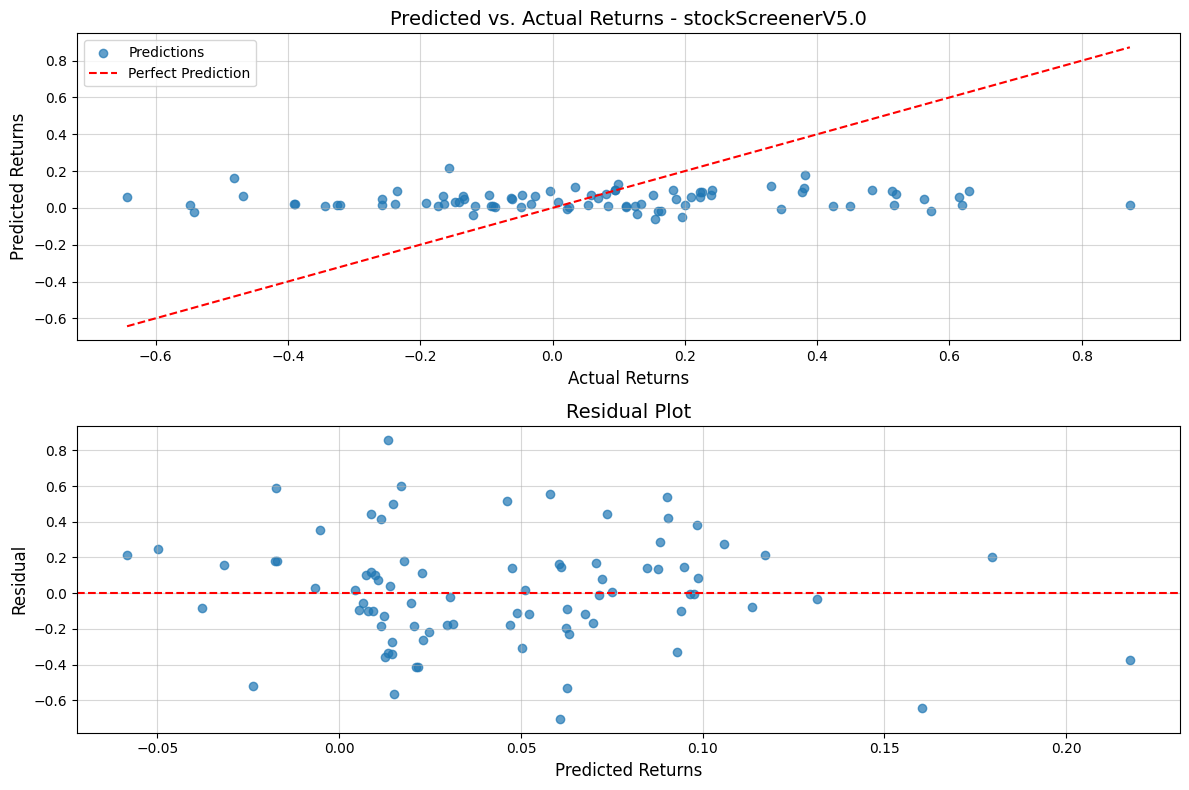

Amount of test tickers: 220, Expected: 220
Evaluation Results:
MAE: 0.237
RMSE: 0.302
R2: -0.002


In [771]:
if trainNewModel == True:
    # Evaluate model
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    
    if not nonTrainingTickers:
        raise ValueError("No tickers available for testing. Ensure nonTrainingTickers is populated correctly.")
    
    if testSize == 'ALL':
        testTickers = nonTrainingTickers
    else:
        testTickers = np.random.choice(nonTrainingTickers, size=min(testSize, len(nonTrainingTickers)), replace=False).tolist()
    
    mae, rmse, r2 = evaluate_model(
        learn=learn,  # Your fastai learner
        testTickers=testTickers,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )
    
    print(f"Amount of test tickers: {len(testTickers)}, Expected: {testSize}")

    if mae is not None and rmse is not None and r2 is not None:
        print(f"Evaluation Results:")
        print(f"MAE: {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"R2: {r2:.3f}")
    else:
        print("Evaluation failed. Metrics are None.")

## Tests

In [772]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.0.pkl
stockScreenerV2.0.pkl
stockScreenerV3.0.pkl
stockScreenerV4.0.pkl
stockScreenerV4.1.pkl
stockScreenerV5.0.pkl


In [773]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV5.0
Timestamp      2025-01-21 21:03
MAE                       0.237
RMSE                      0.302
R2                       -0.002
Name: 5, dtype: object

### Load model

In [774]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

## Predictions

In [782]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

predictionTarget = '8%'

$TFCO: possibly delisted; no price data found  (period=1d)


Error fetching data for TFCO: single positional indexer is out-of-bounds


$MBT: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for MBT: single positional indexer is out-of-bounds


$NOM-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NOM-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NOM-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NOM-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NOM-C&crumb=vSmwn1lwQ8s


Error fetching data for NOM-C: single positional indexer is out-of-bounds


$AMOT: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AMOT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AMOT&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AMOT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AMOT&crumb=vSmwn1lwQ8s


Error fetching data for AMOT: single positional indexer is out-of-bounds


$ARCI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for ARCI: single positional indexer is out-of-bounds


$NILE: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for NILE: single positional indexer is out-of-bounds


$AMIC: possibly delisted; no price data found  (period=1d)


Error fetching data for AMIC: single positional indexer is out-of-bounds


$HITT: possibly delisted; no price data found  (period=1d)


Error fetching data for HITT: single positional indexer is out-of-bounds


$ASCA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ASCA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ASCA&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ASCA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ASCA&crumb=vSmwn1lwQ8s
$TY.P: possibly delisted; no price data found  (period=1d)


Error fetching data for ASCA: single positional indexer is out-of-bounds


$LTD: possibly delisted; no price data found  (period=1d)


Error fetching data for TY.P: single positional indexer is out-of-bounds
Error fetching data for LTD: single positional indexer is out-of-bounds


$MET-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MET-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MET-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MET-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MET-B&crumb=vSmwn1lwQ8s
$KEYW: possibly delisted; no price data found  (period=1d)


Error fetching data for MET-B: single positional indexer is out-of-bounds
Error fetching data for KEYW: single positional indexer is out-of-bounds


$AFAM: possibly delisted; no price data found  (period=1d)


Error fetching data for AFAM: single positional indexer is out-of-bounds


$PES: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$CYNO: possibly delisted; no price data found  (period=1d)


Error fetching data for PES: single positional indexer is out-of-bounds
Error fetching data for CYNO: single positional indexer is out-of-bounds


$HBA-Z: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HBA-Z?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HBA-Z&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HBA-Z?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HBA-Z&crumb=vSmwn1lwQ8s


Error fetching data for HBA-Z: single positional indexer is out-of-bounds


$NQC: possibly delisted; no price data found  (period=1d)


Error fetching data for NQC: single positional indexer is out-of-bounds


$METR: possibly delisted; no price data found  (period=1d)


Error fetching data for METR: single positional indexer is out-of-bounds


$JTA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for JTA: single positional indexer is out-of-bounds


$CTL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CTL: single positional indexer is out-of-bounds


$UFS: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for UFS: single positional indexer is out-of-bounds


$FMFC: possibly delisted; no price data found  (period=1d)


Error fetching data for FMFC: single positional indexer is out-of-bounds


$BPFHP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for BPFHP: single positional indexer is out-of-bounds


$ARH-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARH-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARH-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARH-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARH-C&crumb=vSmwn1lwQ8s


Error fetching data for ARH-C: single positional indexer is out-of-bounds
Error fetching data for TINY: unsupported operand type(s) for *: 'float' and 'NoneType'


$CBF: possibly delisted; no price data found  (period=1d)


Error fetching data for CBF: single positional indexer is out-of-bounds


$DX-A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DX-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DX-A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DX-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DX-A&crumb=vSmwn1lwQ8s


Error fetching data for DX-A: single positional indexer is out-of-bounds


$LSE-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LSE-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LSE-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LSE-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LSE-C&crumb=vSmwn1lwQ8s


Error fetching data for LSE-C: single positional indexer is out-of-bounds


$ISH-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ISH-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ISH-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ISH-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ISH-B&crumb=vSmwn1lwQ8s
$BPZ: possibly delisted; no price data found  (period=1d)


Error fetching data for ISH-B: single positional indexer is out-of-bounds
Error fetching data for BPZ: single positional indexer is out-of-bounds


$ZNGA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for ZNGA: single positional indexer is out-of-bounds


$CNAT: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CNAT: single positional indexer is out-of-bounds
Error fetching data for QQQ: unsupported operand type(s) for *: 'float' and 'NoneType'


$RBS-S: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RBS-S?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RBS-S&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RBS-S?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RBS-S&crumb=vSmwn1lwQ8s


Error fetching data for RBS-S: single positional indexer is out-of-bounds
Error fetching data for QABA: unsupported operand type(s) for *: 'float' and 'NoneType'


$CEM: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CEM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CEM&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CEM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CEM&crumb=vSmwn1lwQ8s


Error fetching data for CEM: single positional indexer is out-of-bounds
Error fetching data for VONV: unsupported operand type(s) for *: 'float' and 'NoneType'


$AUQ: possibly delisted; no price data found  (period=1d)


Error fetching data for AUQ: single positional indexer is out-of-bounds


$DSW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for DSW: single positional indexer is out-of-bounds


$CVC: possibly delisted; no price data found  (period=1d)


Error fetching data for CVC: single positional indexer is out-of-bounds


$PEB-A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PEB-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PEB-A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PEB-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PEB-A&crumb=vSmwn1lwQ8s


Error fetching data for PEB-A: single positional indexer is out-of-bounds


$MSJ: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for MSJ: single positional indexer is out-of-bounds


$NPV-A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPV-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NPV-A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPV-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NPV-A&crumb=vSmwn1lwQ8s


Error fetching data for NPV-A: single positional indexer is out-of-bounds


$NATI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NATI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NATI&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NATI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NATI&crumb=vSmwn1lwQ8s


Error fetching data for NATI: single positional indexer is out-of-bounds


$QIHU: possibly delisted; no price data found  (period=1d)


Error fetching data for QIHU: single positional indexer is out-of-bounds


$SBRAP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SBRAP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SBRAP&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SBRAP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SBRAP&crumb=vSmwn1lwQ8s


Error fetching data for SBRAP: single positional indexer is out-of-bounds
Error fetching data for SLVO: unsupported operand type(s) for *: 'float' and 'NoneType'


$XNPT: possibly delisted; no price data found  (period=1d)


Error fetching data for XNPT: single positional indexer is out-of-bounds


$AGO-F: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AGO-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AGO-F&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AGO-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AGO-F&crumb=vSmwn1lwQ8s


Error fetching data for AGO-F: single positional indexer is out-of-bounds


$TCB-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TCB-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TCB-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TCB-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TCB-C&crumb=vSmwn1lwQ8s
$CPGI: possibly delisted; no price data found  (period=1d)


Error fetching data for TCB-C: single positional indexer is out-of-bounds
Error fetching data for CPGI: single positional indexer is out-of-bounds


$PDLI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$FFNM: possibly delisted; no price data found  (period=1d)


Error fetching data for PDLI: single positional indexer is out-of-bounds
Error fetching data for FFNM: single positional indexer is out-of-bounds


$IDSY: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for IDSY: single positional indexer is out-of-bounds


$HDS: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$END: possibly delisted; no price data found  (period=1d)


Error fetching data for HDS: single positional indexer is out-of-bounds
Error fetching data for END: single positional indexer is out-of-bounds


$RBS-N: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RBS-N?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RBS-N&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RBS-N?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RBS-N&crumb=vSmwn1lwQ8s
$MWR: possibly delisted; no price data found  (period=1d)


Error fetching data for RBS-N: single positional indexer is out-of-bounds


$ALDW: possibly delisted; no price data found  (period=1d)


Error fetching data for MWR: single positional indexer is out-of-bounds
Error fetching data for ALDW: single positional indexer is out-of-bounds


$GRT-G: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GRT-G?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GRT-G&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GRT-G?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GRT-G&crumb=vSmwn1lwQ8s
$AVG: possibly delisted; no price data found  (period=1d)


Error fetching data for GRT-G: single positional indexer is out-of-bounds
Error fetching data for AVG: single positional indexer is out-of-bounds


$MBFI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for MBFI: single positional indexer is out-of-bounds


$MRH: possibly delisted; no price data found  (period=1d)


Error fetching data for MRH: single positional indexer is out-of-bounds


$PYK: possibly delisted; no price data found  (period=1d)


Error fetching data for PYK: single positional indexer is out-of-bounds
Error fetching data for MAGS: unsupported operand type(s) for *: 'float' and 'NoneType'


$CUI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CUI: single positional indexer is out-of-bounds


$ECOL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for ECOL: single positional indexer is out-of-bounds


$WIRE: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WIRE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WIRE&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WIRE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WIRE&crumb=vSmwn1lwQ8s
$IQNT: possibly delisted; no price data found  (period=1d)


Error fetching data for WIRE: single positional indexer is out-of-bounds
Error fetching data for IQNT: single positional indexer is out-of-bounds


$CYBE: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CYBE: single positional indexer is out-of-bounds


$HTGY: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HTGY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HTGY&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HTGY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HTGY&crumb=vSmwn1lwQ8s
$DSCI: possibly delisted; no price data found  (period=1d)


Error fetching data for HTGY: single positional indexer is out-of-bounds


$CXPO: possibly delisted; no price data found  (period=1d)


Error fetching data for DSCI: single positional indexer is out-of-bounds


$SEAC: possibly delisted; no price data found  (period=1d)


Error fetching data for CXPO: single positional indexer is out-of-bounds
Error fetching data for SEAC: single positional indexer is out-of-bounds


$JDSU: possibly delisted; no price data found  (period=1d)


Error fetching data for JDSU: single positional indexer is out-of-bounds


$ANDAW: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$FEFN: possibly delisted; no price data found  (period=1d)


Error fetching data for ANDAW: single positional indexer is out-of-bounds


$NAI: possibly delisted; no price data found  (period=1d)


Error fetching data for FEFN: single positional indexer is out-of-bounds
Error fetching data for NAI: single positional indexer is out-of-bounds


$EPL: possibly delisted; no price data found  (period=1d)


Error fetching data for GLDI: unsupported operand type(s) for *: 'float' and 'NoneType'
Error fetching data for EPL: single positional indexer is out-of-bounds


$NLY-D: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NLY-D?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NLY-D&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NLY-D?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NLY-D&crumb=vSmwn1lwQ8s


Error fetching data for NLY-D: single positional indexer is out-of-bounds


$IGK: possibly delisted; no price data found  (period=1d)


Error fetching data for IGK: single positional indexer is out-of-bounds


$LM: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for LM: single positional indexer is out-of-bounds


$BPI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for BPI: single positional indexer is out-of-bounds


$DISCA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for DISCA: single positional indexer is out-of-bounds


$FBMI: possibly delisted; no price data found  (period=1d)
$CNSL: possibly delisted; no price data found  (period=1d)


Error fetching data for FBMI: single positional indexer is out-of-bounds


$HAYN: possibly delisted; no price data found  (period=1d)


Error fetching data for CNSL: single positional indexer is out-of-bounds


$ISIS: possibly delisted; no price data found  (period=1d)


Error fetching data for HAYN: single positional indexer is out-of-bounds
Error fetching data for ISIS: single positional indexer is out-of-bounds


$TST: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for TST: single positional indexer is out-of-bounds
Error fetching data for BANFP: unsupported operand type(s) for *: 'float' and 'NoneType'


$ATVI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATVI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATVI&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATVI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATVI&crumb=vSmwn1lwQ8s


Error fetching data for ATVI: single positional indexer is out-of-bounds


$OWW: possibly delisted; no price data found  (period=1d)


Error fetching data for OWW: single positional indexer is out-of-bounds


$ANAD: possibly delisted; no price data found  (period=1d)


Error fetching data for ANAD: single positional indexer is out-of-bounds
Error fetching data for XONE: unsupported operand type(s) for *: 'float' and 'NoneType'


$FBC: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for FBC: single positional indexer is out-of-bounds


$ZIPR: possibly delisted; no price data found  (period=1d)


Error fetching data for ZIPR: single positional indexer is out-of-bounds


$REG-F: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/REG-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=REG-F&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/REG-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=REG-F&crumb=vSmwn1lwQ8s


Error fetching data for REG-F: single positional indexer is out-of-bounds


$PERY: possibly delisted; no price data found  (period=1d)
$ATW: possibly delisted; no price data found  (period=1d)


Error fetching data for PERY: single positional indexer is out-of-bounds


$RDA: possibly delisted; no price data found  (period=1d)


Error fetching data for ATW: single positional indexer is out-of-bounds


$NBTF: possibly delisted; no price data found  (period=1d)


Error fetching data for RDA: single positional indexer is out-of-bounds
Error fetching data for NBTF: single positional indexer is out-of-bounds


$LF: possibly delisted; no price data found  (period=1d)
$FFCO: possibly delisted; no price data found  (period=1d)


Error fetching data for LF: single positional indexer is out-of-bounds


$ELN: possibly delisted; no price data found  (period=1d)


Error fetching data for FFCO: single positional indexer is out-of-bounds


$MTS: possibly delisted; no price data found  (period=1d)


Error fetching data for ELN: single positional indexer is out-of-bounds
Error fetching data for MTS: single positional indexer is out-of-bounds


$LLTC: possibly delisted; no price data found  (period=1d)


Error fetching data for LLTC: single positional indexer is out-of-bounds


$BODY: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BODY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BODY&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BODY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BODY&crumb=vSmwn1lwQ8s
$CBA: possibly delisted; no price data found  (period=1d)


Error fetching data for BODY: single positional indexer is out-of-bounds
Error fetching data for CBA: single positional indexer is out-of-bounds
Error fetching data for TVE: unsupported operand type(s) for *: 'float' and 'NoneType'


$JRJC: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for JRJC: single positional indexer is out-of-bounds


$OXLC: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OXLC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OXLC&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OXLC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OXLC&crumb=vSmwn1lwQ8s


Error fetching data for OXLC: single positional indexer is out-of-bounds


$EVBS: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVBS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVBS&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/EVBS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=EVBS&crumb=vSmwn1lwQ8s


Error fetching data for EVBS: single positional indexer is out-of-bounds


Failed to get ticker 'ELTK' reason: Expecting value: line 1 column 1 (char 0)
$ELTK: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ELTK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ELTK&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ELTK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ELTK&crumb=vSmwn1lwQ8s


Error fetching data for ELTK: single positional indexer is out-of-bounds


Failed to get ticker 'TTF' reason: Expecting value: line 1 column 1 (char 0)
$TTF: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TTF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TTF&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TTF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TTF&crumb=vSmwn1lwQ8s


Error fetching data for TTF: single positional indexer is out-of-bounds


Failed to get ticker 'ATSG' reason: Expecting value: line 1 column 1 (char 0)
$ATSG: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATSG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATSG&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ATSG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ATSG&crumb=vSmwn1lwQ8s


Error fetching data for ATSG: single positional indexer is out-of-bounds


Failed to get ticker 'MXF' reason: Expecting value: line 1 column 1 (char 0)
$MXF: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MXF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MXF&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MXF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MXF&crumb=vSmwn1lwQ8s


Error fetching data for MXF: single positional indexer is out-of-bounds


$SHBI: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SHBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SHBI&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SHBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SHBI&crumb=vSmwn1lwQ8s


Error fetching data for SHBI: single positional indexer is out-of-bounds


Failed to get ticker 'COLM' reason: Expecting value: line 1 column 1 (char 0)
$COLM: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/COLM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=COLM&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/COLM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=COLM&crumb=vSmwn1lwQ8s


Error fetching data for COLM: single positional indexer is out-of-bounds


Failed to get ticker 'MEG' reason: Expecting value: line 1 column 1 (char 0)
$MEG: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MEG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MEG&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MEG?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MEG&crumb=vSmwn1lwQ8s


Error fetching data for MEG: single positional indexer is out-of-bounds


Failed to get ticker 'ARNA' reason: Expecting value: line 1 column 1 (char 0)
$ARNA: possibly delisted; no price data found  (period=1d)
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARNA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARNA&crumb=vSmwn1lwQ8s
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ARNA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ARNA&crumb=vSmwn1lwQ8s


Error fetching data for ARNA: single positional indexer is out-of-bounds


Failed to get ticker 'DD-B' reason: Expecting value: line 1 column 1 (char 0)
$DD-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DD-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DD-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DD-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DD-B&crumb=vSmwn1lwQ8s


Error fetching data for DD-B: single positional indexer is out-of-bounds


$KED: possibly delisted; no price data found  (period=1d)


Error fetching data for KED: single positional indexer is out-of-bounds
Error fetching data for TSL: unsupported operand type(s) for *: 'float' and 'NoneType'


$CADX: possibly delisted; no price data found  (period=1d)


Error fetching data for CADX: single positional indexer is out-of-bounds


$AMCC: possibly delisted; no price data found  (period=1d)


Error fetching data for AMCC: single positional indexer is out-of-bounds


$PRLS: possibly delisted; no price data found  (period=1d)


Error fetching data for PRLS: single positional indexer is out-of-bounds


$TEU-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TEU-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TEU-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TEU-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TEU-C&crumb=vSmwn1lwQ8s


Error fetching data for TEU-C: single positional indexer is out-of-bounds


$LMCA: possibly delisted; no price data found  (period=1d)


Error fetching data for LMCA: single positional indexer is out-of-bounds


$EXA: possibly delisted; no price data found  (period=1d)


Error fetching data for USG: unsupported operand type(s) for *: 'float' and 'NoneType'
Error fetching data for EXA: single positional indexer is out-of-bounds


$IKNX: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$ENI: possibly delisted; no price data found  (period=1d)


Error fetching data for IKNX: single positional indexer is out-of-bounds
Error fetching data for ENI: single positional indexer is out-of-bounds


$SIRO: possibly delisted; no price data found  (period=1d)


Error fetching data for SIRO: single positional indexer is out-of-bounds


$PCL: possibly delisted; no price data found  (period=1d)


Error fetching data for PCL: single positional indexer is out-of-bounds


$COLE: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for COLE: single positional indexer is out-of-bounds


$SYMX: possibly delisted; no price data found  (period=1d)


Error fetching data for SYMX: single positional indexer is out-of-bounds


$GLOG: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$NKA: possibly delisted; no price data found  (period=1d)


Error fetching data for GLOG: single positional indexer is out-of-bounds
Error fetching data for NKA: single positional indexer is out-of-bounds


$INOC: possibly delisted; no price data found  (period=1d)


Error fetching data for INOC: single positional indexer is out-of-bounds


$AMP-A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AMP-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AMP-A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AMP-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AMP-A&crumb=vSmwn1lwQ8s


Error fetching data for AMP-A: single positional indexer is out-of-bounds


$C-E: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/C-E?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=C-E&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/C-E?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=C-E&crumb=vSmwn1lwQ8s


Error fetching data for C-E: single positional indexer is out-of-bounds


$CCMP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CCMP: single positional indexer is out-of-bounds


$DNKN: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for DNKN: single positional indexer is out-of-bounds


$SKH: possibly delisted; no price data found  (period=1d)


Error fetching data for SKH: single positional indexer is out-of-bounds


$AYR: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for AYR: single positional indexer is out-of-bounds


$CCG-A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCG-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCG-A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCG-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCG-A&crumb=vSmwn1lwQ8s


Error fetching data for CCG-A: single positional indexer is out-of-bounds


$CNIT: possibly delisted; no price data found  (period=1d)


Error fetching data for CNIT: single positional indexer is out-of-bounds


$ZMH: possibly delisted; no price data found  (period=1d)


Error fetching data for ZMH: single positional indexer is out-of-bounds


$HFBL: possibly delisted; no price data found  (period=1d)


Error fetching data for HFBL: single positional indexer is out-of-bounds


$VCI: possibly delisted; no price data found  (period=1d)


Error fetching data for VCI: single positional indexer is out-of-bounds


$LBF: possibly delisted; no price data found  (period=1d)


Error fetching data for LBF: single positional indexer is out-of-bounds


$BEE-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BEE-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BEE-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BEE-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BEE-B&crumb=vSmwn1lwQ8s


Error fetching data for BEE-B: single positional indexer is out-of-bounds


$FLTX: possibly delisted; no price data found  (period=1d)


Error fetching data for FLTX: single positional indexer is out-of-bounds


$NASB: possibly delisted; no price data found  (period=1d)


Error fetching data for NASB: single positional indexer is out-of-bounds


$ACTS: possibly delisted; no price data found  (period=1d)


Error fetching data for ACTS: single positional indexer is out-of-bounds


$PTNT: possibly delisted; no price data found  (period=1d)


Error fetching data for PTNT: single positional indexer is out-of-bounds


$XVG: possibly delisted; no price data found  (period=1d)


Error fetching data for XVG: single positional indexer is out-of-bounds


$IXYS: possibly delisted; no price data found  (period=1d)


Error fetching data for IXYS: single positional indexer is out-of-bounds


$SPPI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPPI&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPPI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPPI&crumb=vSmwn1lwQ8s


Error fetching data for SPPI: single positional indexer is out-of-bounds


$FSCFL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for FSCFL: single positional indexer is out-of-bounds


$UPI: possibly delisted; no price data found  (period=1d)


Error fetching data for UPI: single positional indexer is out-of-bounds


$RSO-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RSO-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RSO-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RSO-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RSO-B&crumb=vSmwn1lwQ8s


Error fetching data for RSO-B: single positional indexer is out-of-bounds


$DNI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for DNI: single positional indexer is out-of-bounds


$CU: possibly delisted; no price data found  (period=1d)


Error fetching data for CU: single positional indexer is out-of-bounds


$BONA: possibly delisted; no price data found  (period=1d)
$RBPAA: possibly delisted; no price data found  (period=1d)


Error fetching data for BONA: single positional indexer is out-of-bounds
Error fetching data for RBPAA: single positional indexer is out-of-bounds


$MSCA: possibly delisted; no price data found  (period=1d)


Error fetching data for MSCA: single positional indexer is out-of-bounds


$NEWL: possibly delisted; no price data found  (period=1d)


Error fetching data for NEWL: single positional indexer is out-of-bounds


$TXI: possibly delisted; no price data found  (period=1d)


Error fetching data for TXI: single positional indexer is out-of-bounds


$EEML: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$EXL: possibly delisted; no price data found  (period=1d)


Error fetching data for EEML: single positional indexer is out-of-bounds


$GALE: possibly delisted; no price data found  (period=1d)


Error fetching data for EXL: single positional indexer is out-of-bounds
Error fetching data for GALE: single positional indexer is out-of-bounds


$LVNTA: possibly delisted; no price data found  (period=1d)
$AHGP: possibly delisted; no price data found  (period=1d)


Error fetching data for LVNTA: single positional indexer is out-of-bounds
Error fetching data for AHGP: single positional indexer is out-of-bounds


$ACFC: possibly delisted; no price data found  (period=1d)


Error fetching data for ACFC: single positional indexer is out-of-bounds


$TAYCO: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TAYCO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TAYCO&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TAYCO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TAYCO&crumb=vSmwn1lwQ8s


Error fetching data for TAYCO: single positional indexer is out-of-bounds


$DTLK: possibly delisted; no price data found  (period=1d)


Error fetching data for DTLK: single positional indexer is out-of-bounds


$REXI: possibly delisted; no price data found  (period=1d)


Error fetching data for REXI: single positional indexer is out-of-bounds


$PNX: possibly delisted; no price data found  (period=1d)


Error fetching data for PNX: single positional indexer is out-of-bounds


$TCC: possibly delisted; no price data found  (period=1d)
$LRY: possibly delisted; no price data found  (period=1d)


Error fetching data for TCC: single positional indexer is out-of-bounds


$NMA: possibly delisted; no price data found  (period=1d)


Error fetching data for LRY: single positional indexer is out-of-bounds
Error fetching data for NMA: single positional indexer is out-of-bounds


$ZB-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ZB-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ZB-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ZB-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ZB-C&crumb=vSmwn1lwQ8s


Error fetching data for ZB-C: single positional indexer is out-of-bounds


$PMCS: possibly delisted; no price data found  (period=1d)


Error fetching data for PMCS: single positional indexer is out-of-bounds


$NCIT: possibly delisted; no price data found  (period=1d)


Error fetching data for NCIT: single positional indexer is out-of-bounds


$BDGE: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for BDGE: single positional indexer is out-of-bounds


$BEE-A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BEE-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BEE-A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BEE-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BEE-A&crumb=vSmwn1lwQ8s
$VRNM: possibly delisted; no price data found  (period=1d)


Error fetching data for BEE-A: single positional indexer is out-of-bounds
Error fetching data for VRNM: single positional indexer is out-of-bounds


$LDL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for LDL: single positional indexer is out-of-bounds


$NIQ: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NIQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NIQ&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NIQ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NIQ&crumb=vSmwn1lwQ8s


Error fetching data for NIQ: single positional indexer is out-of-bounds


$ALR-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ALR-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ALR-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ALR-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ALR-B&crumb=vSmwn1lwQ8s


Error fetching data for ALR-B: single positional indexer is out-of-bounds


$GA: possibly delisted; no price data found  (period=1d)


Error fetching data for VNQI: unsupported operand type(s) for *: 'float' and 'NoneType'
Error fetching data for GA: single positional indexer is out-of-bounds


$HJV: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for HJV: single positional indexer is out-of-bounds


$SCH-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SCH-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SCH-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SCH-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SCH-B&crumb=vSmwn1lwQ8s


Error fetching data for SCH-B: single positional indexer is out-of-bounds


$NMY: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$PLP: possibly delisted; no price data found  (period=1d)


Error fetching data for NMY: single positional indexer is out-of-bounds


$EDS: possibly delisted; no price data found  (period=1d)


Error fetching data for PLP: single positional indexer is out-of-bounds


$ARG: possibly delisted; no price data found  (period=1d)


Error fetching data for EDS: single positional indexer is out-of-bounds
Error fetching data for ARG: single positional indexer is out-of-bounds


$USCR: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for USCR: single positional indexer is out-of-bounds


$LLEN: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for LLEN: single positional indexer is out-of-bounds


$AKP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for AKP: single positional indexer is out-of-bounds


$CPWR: possibly delisted; no price data found  (period=1d)
$HVB: possibly delisted; no price data found  (period=1d)


Error fetching data for CPWR: single positional indexer is out-of-bounds
Error fetching data for HVB: single positional indexer is out-of-bounds


$QEP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for QEP: single positional indexer is out-of-bounds


$LMNX: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$HOLL: possibly delisted; no price data found  (period=1d)


Error fetching data for LMNX: single positional indexer is out-of-bounds
Error fetching data for HOLL: single positional indexer is out-of-bounds


$IRE-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/IRE-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=IRE-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/IRE-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=IRE-B&crumb=vSmwn1lwQ8s


Error fetching data for IRE-B: single positional indexer is out-of-bounds


$ARO: possibly delisted; no price data found  (period=1d)
$CBNJ: possibly delisted; no price data found  (period=1d)


Error fetching data for ARO: single positional indexer is out-of-bounds
Error fetching data for CBNJ: single positional indexer is out-of-bounds


$HGR: possibly delisted; no price data found  (period=1d)


Error fetching data for HGR: single positional indexer is out-of-bounds


$NRF-B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NRF-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NRF-B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NRF-B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NRF-B&crumb=vSmwn1lwQ8s


Error fetching data for NRF-B: single positional indexer is out-of-bounds


$SRC: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SRC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SRC&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SRC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SRC&crumb=vSmwn1lwQ8s


Error fetching data for SRC: single positional indexer is out-of-bounds


$CVT: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CVT: single positional indexer is out-of-bounds


$SNV-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SNV-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SNV-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SNV-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SNV-C&crumb=vSmwn1lwQ8s


Error fetching data for SNV-C: single positional indexer is out-of-bounds


$BIOL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BIOL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BIOL&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BIOL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BIOL&crumb=vSmwn1lwQ8s


Error fetching data for BIOL: single positional indexer is out-of-bounds


$CTIB: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CTIB?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CTIB&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CTIB?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CTIB&crumb=vSmwn1lwQ8s


Error fetching data for CTIB: single positional indexer is out-of-bounds


$SCE-F: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SCE-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SCE-F&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SCE-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SCE-F&crumb=vSmwn1lwQ8s
$GAI: possibly delisted; no price data found  (period=1d)


Error fetching data for SCE-F: single positional indexer is out-of-bounds
Error fetching data for GAI: single positional indexer is out-of-bounds


$AVV: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AVV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AVV&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AVV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AVV&crumb=vSmwn1lwQ8s
$REXX: possibly delisted; no price data found  (period=1d)


Error fetching data for AVV: single positional indexer is out-of-bounds
Error fetching data for REXX: single positional indexer is out-of-bounds


$CVB: possibly delisted; no price data found  (period=1d)


Error fetching data for CVB: single positional indexer is out-of-bounds


$IFSM: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for IFSM: single positional indexer is out-of-bounds


$TAST: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TAST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TAST&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TAST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TAST&crumb=vSmwn1lwQ8s


Error fetching data for TAST: single positional indexer is out-of-bounds


$TAP.A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TAP.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TAP.A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TAP.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TAP.A&crumb=vSmwn1lwQ8s
$LXK: possibly delisted; no price data found  (period=1d)


Error fetching data for TAP.A: single positional indexer is out-of-bounds
Error fetching data for LXK: single positional indexer is out-of-bounds


$NUO: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NUO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NUO&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NUO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NUO&crumb=vSmwn1lwQ8s


Error fetching data for NUO: single positional indexer is out-of-bounds


$EMMS: possibly delisted; no price data found  (period=1d)


Error fetching data for EMMS: single positional indexer is out-of-bounds


$NKG-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NKG-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NKG-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NKG-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NKG-C&crumb=vSmwn1lwQ8s


Error fetching data for NKG-C: single positional indexer is out-of-bounds


$BNNY: possibly delisted; no price data found  (period=1d)


Error fetching data for BNNY: single positional indexer is out-of-bounds


$HCAP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for HCAP: single positional indexer is out-of-bounds


$DEPO: possibly delisted; no price data found  (period=1d)


Error fetching data for DEPO: single positional indexer is out-of-bounds


$DDR-J: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DDR-J?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DDR-J&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DDR-J?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DDR-J&crumb=vSmwn1lwQ8s


Error fetching data for DDR-J: single positional indexer is out-of-bounds


$CPAH: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for CPAH: single positional indexer is out-of-bounds


$Q: possibly delisted; no price data found  (period=1d)


Error fetching data for Q: single positional indexer is out-of-bounds


$UBP-F: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UBP-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=UBP-F&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UBP-F?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=UBP-F&crumb=vSmwn1lwQ8s


Error fetching data for UBP-F: single positional indexer is out-of-bounds


$BRK.A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for BRK.A: single positional indexer is out-of-bounds


$CCV: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCV&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CCV?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CCV&crumb=vSmwn1lwQ8s


Error fetching data for CCV: single positional indexer is out-of-bounds


$FRF: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for FRF: single positional indexer is out-of-bounds


$MSFG: possibly delisted; no price data found  (period=1d)


Error fetching data for MSFG: single positional indexer is out-of-bounds


$LOGM: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for LOGM: single positional indexer is out-of-bounds


$UAM: possibly delisted; no price data found  (period=1d)


Error fetching data for UAM: single positional indexer is out-of-bounds


$GM.A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GM.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GM.A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GM.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GM.A&crumb=vSmwn1lwQ8s


Error fetching data for GM.A: single positional indexer is out-of-bounds


$HFC: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$ATML: possibly delisted; no price data found  (period=1d)


Error fetching data for HFC: single positional indexer is out-of-bounds


$SWS: possibly delisted; no price data found  (period=1d)


Error fetching data for ATML: single positional indexer is out-of-bounds
Error fetching data for SWS: single positional indexer is out-of-bounds


$SSFN: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for SSFN: single positional indexer is out-of-bounds


$CMCSK: possibly delisted; no price data found  (period=1d)


Error fetching data for CMCSK: single positional indexer is out-of-bounds


$JACQ: possibly delisted; no price data found  (period=1d)


Error fetching data for JACQ: single positional indexer is out-of-bounds


$IRG: possibly delisted; no price data found  (period=1d)


Error fetching data for IRG: single positional indexer is out-of-bounds


$APB: possibly delisted; no price data found  (period=1d)


Error fetching data for APB: single positional indexer is out-of-bounds


$NTX-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NTX-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NTX-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NTX-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NTX-C&crumb=vSmwn1lwQ8s


Error fetching data for NTX-C: single positional indexer is out-of-bounds


$TAI: possibly delisted; no price data found  (period=1d)
$IL: possibly delisted; no price data found  (period=1d)


Error fetching data for TAI: single positional indexer is out-of-bounds
Error fetching data for IL: single positional indexer is out-of-bounds


$EBSB: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for EBSB: single positional indexer is out-of-bounds


$BPL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for BPL: single positional indexer is out-of-bounds


$GDP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for GDP: single positional indexer is out-of-bounds


$GAINP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for GAINP: single positional indexer is out-of-bounds
Error fetching data for DGRS: unsupported operand type(s) for *: 'float' and 'NoneType'


$AFQ: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for AFQ: single positional indexer is out-of-bounds


$GS-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GS-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GS-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GS-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GS-C&crumb=vSmwn1lwQ8s


Error fetching data for GS-C: single positional indexer is out-of-bounds


$AMAG: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for AMAG: single positional indexer is out-of-bounds


$LIWA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for LIWA: single positional indexer is out-of-bounds
Error fetching data for LION: unsupported operand type(s) for *: 'float' and 'NoneType'


$MEN: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for MEN: single positional indexer is out-of-bounds


$ROIA: possibly delisted; no price data found  (period=1d)


Error fetching data for ROIA: single positional indexer is out-of-bounds


$STLY: possibly delisted; no price data found  (period=1d)


Error fetching data for STLY: single positional indexer is out-of-bounds


$OXBT: possibly delisted; no price data found  (period=1d)


Error fetching data for OXBT: single positional indexer is out-of-bounds
Error fetching data for PRFZ: unsupported operand type(s) for *: 'float' and 'NoneType'


$PJS: possibly delisted; no price data found  (period=1d)


Error fetching data for PJS: single positional indexer is out-of-bounds


$OAS: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$COBZ: possibly delisted; no price data found  (period=1d)


Error fetching data for OAS: single positional indexer is out-of-bounds


$CIMT: possibly delisted; no price data found  (period=1d)


Error fetching data for COBZ: single positional indexer is out-of-bounds
Error fetching data for CIMT: single positional indexer is out-of-bounds


$PSA-R: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PSA-R?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PSA-R&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PSA-R?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PSA-R&crumb=vSmwn1lwQ8s
$ORIG: possibly delisted; no price data found  (period=1d)


Error fetching data for PSA-R: single positional indexer is out-of-bounds


$DRU: possibly delisted; no price data found  (period=1d)


Error fetching data for ORIG: single positional indexer is out-of-bounds
Error fetching data for DRU: single positional indexer is out-of-bounds


$PVD: possibly delisted; no price data found  (period=1d)


Error fetching data for PVD: single positional indexer is out-of-bounds


$EQU: possibly delisted; no price data found  (period=1d)


Error fetching data for EQU: single positional indexer is out-of-bounds


$RMGN: possibly delisted; no price data found  (period=1d)
$SFD: possibly delisted; no price data found  (period=1d)


Error fetching data for RMGN: single positional indexer is out-of-bounds
Error fetching data for SFD: single positional indexer is out-of-bounds


$UCBI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UCBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=UCBI&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UCBI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=UCBI&crumb=vSmwn1lwQ8s
$BCR: possibly delisted; no price data found  (period=1d)


Error fetching data for UCBI: single positional indexer is out-of-bounds
Error fetching data for BCR: single positional indexer is out-of-bounds


$EFUT: possibly delisted; no price data found  (period=1d)


Error fetching data for EFUT: single positional indexer is out-of-bounds


$GCOM: possibly delisted; no price data found  (period=1d)


Error fetching data for GCOM: single positional indexer is out-of-bounds


$SGYP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for SGYP: single positional indexer is out-of-bounds


$ONTX: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for ONTX: single positional indexer is out-of-bounds


$FALC: possibly delisted; no price data found  (period=1d)


Error fetching data for FALC: single positional indexer is out-of-bounds


$HZNP: possibly delisted; no price data found  (period=1d)


Error fetching data for HZNP: single positional indexer is out-of-bounds


$HITK: possibly delisted; no price data found  (period=1d)


Error fetching data for HITK: single positional indexer is out-of-bounds


$MOG.B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MOG.B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MOG.B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MOG.B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MOG.B&crumb=vSmwn1lwQ8s


Error fetching data for MOG.B: single positional indexer is out-of-bounds


$PNY: possibly delisted; no price data found  (period=1d)


Error fetching data for PNY: single positional indexer is out-of-bounds


$THTI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$WCRX: possibly delisted; no price data found  (period=1d)


Error fetching data for THTI: single positional indexer is out-of-bounds
Error fetching data for WCRX: single positional indexer is out-of-bounds


$MY: possibly delisted; no price data found  (period=1d)


Error fetching data for MY: single positional indexer is out-of-bounds
Error fetching data for INVN: unsupported operand type(s) for *: 'float' and 'NoneType'


$RNR-E: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RNR-E?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RNR-E&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RNR-E?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RNR-E&crumb=vSmwn1lwQ8s
$MSCC: possibly delisted; no price data found  (period=1d)


Error fetching data for RNR-E: single positional indexer is out-of-bounds
Error fetching data for MSCC: single positional indexer is out-of-bounds
Error fetching data for PFH: unsupported operand type(s) for *: 'float' and 'NoneType'


$AGN: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for AGN: single positional indexer is out-of-bounds


$RDS.B: possibly delisted; no price data found  (period=1d)


Error fetching data for RDS.B: single positional indexer is out-of-bounds


$OC.B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OC.B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OC.B&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OC.B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OC.B&crumb=vSmwn1lwQ8s


Error fetching data for OC.B: single positional indexer is out-of-bounds


$BK-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BK-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BK-C&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BK-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BK-C&crumb=vSmwn1lwQ8s
$KMM: possibly delisted; no price data found  (period=1d)


Error fetching data for BK-C: single positional indexer is out-of-bounds
Error fetching data for KMM: single positional indexer is out-of-bounds


$ADEP: possibly delisted; no price data found  (period=1d)
$NPSP: possibly delisted; no price data found  (period=1d)


Error fetching data for ADEP: single positional indexer is out-of-bounds
Error fetching data for NPSP: single positional indexer is out-of-bounds


$CSUN: possibly delisted; no price data found  (period=1d)


Error fetching data for CSUN: single positional indexer is out-of-bounds


$PICO: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for PICO: single positional indexer is out-of-bounds


$PULB: possibly delisted; no price data found  (period=1d)


Error fetching data for PULB: single positional indexer is out-of-bounds


$ICA: possibly delisted; no price data found  (period=1d)


Error fetching data for ICA: single positional indexer is out-of-bounds


$OCLR: possibly delisted; no price data found  (period=1d)


Error fetching data for OCLR: single positional indexer is out-of-bounds


$NQ: possibly delisted; no price data found  (period=1d)


Error fetching data for NQ: single positional indexer is out-of-bounds


$GOM: possibly delisted; no price data found  (period=1d)


Error fetching data for GOM: single positional indexer is out-of-bounds


$MERU: possibly delisted; no price data found  (period=1d)


Error fetching data for MERU: single positional indexer is out-of-bounds


$IMF: possibly delisted; no price data found  (period=1d)


Error fetching data for IMF: single positional indexer is out-of-bounds


$DPS: possibly delisted; no price data found  (period=1d)


Error fetching data for DPS: single positional indexer is out-of-bounds


$XWES: possibly delisted; no price data found  (period=1d)


Error fetching data for XWES: single positional indexer is out-of-bounds


$PVG: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for PVG: single positional indexer is out-of-bounds


$UBP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UBP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=UBP&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UBP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=UBP&crumb=vSmwn1lwQ8s


Error fetching data for UBP: single positional indexer is out-of-bounds


$NNJ: possibly delisted; no price data found  (period=1d)


Error fetching data for NNJ: single positional indexer is out-of-bounds


$OFC: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OFC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OFC&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OFC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OFC&crumb=vSmwn1lwQ8s


Error fetching data for OFC: single positional indexer is out-of-bounds


$TNP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TNP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TNP&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TNP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=TNP&crumb=vSmwn1lwQ8s


Error fetching data for TNP: single positional indexer is out-of-bounds


$NAN-D: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NAN-D?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NAN-D&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NAN-D?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NAN-D&crumb=vSmwn1lwQ8s


Error fetching data for NAN-D: single positional indexer is out-of-bounds


$NPM: possibly delisted; no price data found  (period=1d)


Error fetching data for NPM: single positional indexer is out-of-bounds


$GKNT: possibly delisted; no price data found  (period=1d)


Error fetching data for GKNT: single positional indexer is out-of-bounds


$CCSC: possibly delisted; no price data found  (period=1d)
$DWCH: possibly delisted; no price data found  (period=1d)


Error fetching data for CCSC: single positional indexer is out-of-bounds
Error fetching data for DWCH: single positional indexer is out-of-bounds


$CWEI: possibly delisted; no price data found  (period=1d)


Error fetching data for CWEI: single positional indexer is out-of-bounds


$FPT: possibly delisted; no price data found  (period=1d)


Error fetching data for FPT: single positional indexer is out-of-bounds


$WLB: possibly delisted; no price data found  (period=1d)


Error fetching data for WLB: single positional indexer is out-of-bounds


$MCRS: possibly delisted; no price data found  (period=1d)


Error fetching data for MCRS: single positional indexer is out-of-bounds


$TKMR: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for TKMR: single positional indexer is out-of-bounds


$CEC: possibly delisted; no price data found  (period=1d)


Error fetching data for CEC: single positional indexer is out-of-bounds


$NNP: possibly delisted; no price data found  (period=1d)


Error fetching data for NNP: single positional indexer is out-of-bounds


$HVT.A: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HVT.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HVT.A&crumb=vSmwn1lwQ8s
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HVT.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HVT.A&crumb=vSmwn1lwQ8s
$SFN: possibly delisted; no price data found  (period=1d)


Error fetching data for HVT.A: single positional indexer is out-of-bounds
Error fetching data for SFN: single positional indexer is out-of-bounds


$QIWI: possibly delisted; no price data found  (period=1d)


Error fetching data for QIWI: single positional indexer is out-of-bounds


$LINTB: possibly delisted; no price data found  (period=1d)


Error fetching data for LINTB: single positional indexer is out-of-bounds


$TCRD: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for TCRD: single positional indexer is out-of-bounds


$WIFI: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for WIFI: single positional indexer is out-of-bounds


$LPTN: possibly delisted; no price data found  (period=1d)


Error fetching data for LPTN: single positional indexer is out-of-bounds


$ANDA: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for ANDA: single positional indexer is out-of-bounds


C:\Users\Gamer\AppData\Local\Temp\ipykernel_14704\2308496462.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)
c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

Got predictions for 235 tickers, expected: 578
Prediction for best performing tickers:
NBTF (NB&T Financial Group Inc): 483.31%
RDHL (Redhill Biopharma Ltd.): 65.50%
EBR (Centrais Elc Braz Pfb B Elbras): 63.42%
MUA (Blackrock Muniassets Fund): 25.28%
KEYW (The Keyw Holding Corp.): 23.11%
HTCO (Hickory Tech Corp.): 22.27%
AVG (Avg Technologies N.V.): 19.24%
TEU-C (Box Ships Inc.): 18.42%
SOHO (Sotherly Hotels Inc.): 18.07%
LSE-C (Caplease Inc.): 15.93%
ENZ (Enzo Biochem): 15.27%
CHCO (City Holding Company): 14.43%
GLDI (Credit Suisse Ag): 14.29%
DSCI (Derma Sciences): 14.26%
HOV (Hovnanian Enterprises Inc): 13.51%
AGO-F (Assured Guaranty Ltd [F]): 13.40%
USG (Usg Corp.): 12.30%
XONE (The Exone Company): 12.07%
ARCI (Appliance Recycling Centers): 11.67%
AFAM (Almost Family Inc): 11.39%
ATSG (Air Transport Services Group Inc): 11.39%
TST (Thestreet.Com): 11.38%
ATW (Atwood Oceanics): 11.02%
ZIPR (Ziprealty): 10.99%
HIG (Hartford Financial Services Group): 10.78%
PDLI (Pdl Biopharma): 10.7